In [7]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", """Anda adalah asisten yang membantu. Jawab semua pertanyaan sebaik
        kemampuan Anda."""),
    ("placeholder", "{messages}"),
])

 

chain = prompt | llm | StrOutputParser()

chain.invoke({
    "messages": [
        ("human","""Terjemahkan kalimat ini dari Bahasa Inggris ke Prancis: I like
            programing."""),
        ("ai", "J'adore programmer."),
        ("human", "Apa yang baru saja Anda katakan?"),
    ],
})

'Saya baru saja menerjemahkan kalimat "I like programming" dari Bahasa Inggris ke Prancis, yang dalam hal ini menjadi "J\'adore programmer." Artinya adalah "Saya suka memprogram."'

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Pesan memiliki tipe "list". Fungsi `add_messages`
    # dalam anotasi menentukan bagaimana status ini seharusnya
    # diperbarui (dalam kasus ini, ia menambahkan pesan baru ke
    # list, daripada mengganti pesan sebelumnya)
	messages: Annotated[list, add_messages]

builder = StateGraph(State)

In [3]:
def chatbot(state: State):
    answer = llm.invoke(state["messages"])
    return {"messages": [answer]}

# Argumen pertama adalah nama simpul unik
# Argumen kedua adalah fungsi atau Runnable yang akan dijalankan
builder.add_node("chatbot", chatbot)

In [4]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

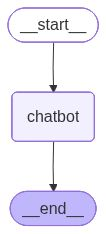

In [ ]:

png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))


In [10]:
input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)


{'chatbot': {'messages': [AIMessage(content='Hello! ٩(◕‿◕｡)۶ How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 10, 'total_tokens': 30, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen3-coder-plus', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0fa30537-8001-4e66-b01f-9875102fa1ab-0', usage_metadata={'input_tokens': 10, 'output_tokens': 20, 'total_tokens': 30})]}}
